In [1]:
using Knet

In [2]:
using Images, ImageView, Colors

In [3]:
using Plots

In [251]:
include("data/chi2d.jl")
include("chi2d_objectives.jl");

In [252]:
function up!(w,lr,dw)
    for i in 1:length(w)
        # dw[i] == nothing represents w[i] not being used 
        # during forward pass recording of gradient.
        # Therefore, dw[i] is not assigned, and is nothing
        if dw[i] ≠ nothing
            w[i] -= lr * dw[i]
        end
    end    
end

up! (generic function with 1 method)

In [253]:
function linesearch!(w,x,y,lr=.1,s=1.5)
    #loss0 = loss(w,x,y)
    #dw = lossgradient(w,x,y)
    dw, loss0 = gradlossgradient(w,x,y)
    
    if s <= 1.0
        up!(w,lr,dw)
        return lr
    end
    
    w0 = copy(w)
    up!(w,lr,dw)
    loss1 = loss(w,x,y)
    
    if loss1 < loss0
        lr *= s
    else
        while loss1 >= loss0 || isnan(loss1) || isinf(loss1)
            lr /= s
            copy!(w,w0)
            up!(w,lr,dw)
            loss1 = loss(w,x,y)
        end
    end
    
    return lr
end

linesearch! (generic function with 3 methods)

In [254]:
# SGD training loop
function train_sgd!(w, data; lr=.1, s=-1.0)
    for (x,y) in data
        lr = linesearch!(w,x,y,lr,s)
    end
    return lr
end

train_sgd! (generic function with 1 method)

In [255]:
# define misc. params
seed  = 42
Ftype = Float32
# Atype = Array{Ftype}
Atype = KnetArray{Ftype}
atype = Atype
srand(seed);

In [256]:
# data params
bs = 5 # batch size
ep = 100 # epochs

100

In [269]:
const T  = 1 # number of "time steps" for xₜ
const C  = 3 # number of fc terms
const Nr = 7 # number of regularization terms in each fc
const Nd = 7 # number of data fidelity terms in each fc
const Nw = 7 # number of radial basis functions in each influence function
const sr = 5 # size of kernel for regularization term convolutions is [sr×sr]
const sd = 5 # size of kernel for data fidelity term convolutions is [sr×sr]
const cycle = "random" # access pattern function c(t)

p = params_kobler(atype=atype,seed=seed,cycle=cycle,C=C,T=T,Nr=Nr,Nd=Nd,Nw=Nw,sr=sr,sd=sd)
weights() = weights_kobler(p)
predict(w,x) = predict_kobler(w,x,p)
loss(w,x,y) = loss_kobler(w,x,y,p)
lossgradient = grad(loss)
gradlossgradient = gradloss(loss)
#accuracy(w,data,predict) = sum(map(d->loss(w,d[1],d[2]),data))

(::gradfun) (generic function with 1 method)

In [270]:
xtrn,ytrn,xtst,ytst = chi2d(atype=atype)
dtrn = minibatch(xtrn, ytrn, bs, xtype=atype, ytype=atype)
dtst = minibatch(xtst, ytst, bs, xtype=atype, ytype=atype)
w = weights();
#prms = params(w, o)

In [271]:
# initial weights and loss
lr = Ftype(1e-3) # learning rate
s  = Ftype(1.5) # line search parameter
w  = weights()
ws = [copy(w)]
losses = [loss(w,xtrn,ytrn)]

1-element Array{Float32,1}:
 340.687

In [275]:
# Record the weights and losses for `ep` epochs
for epoch in 1:ep
    @time lr = train_sgd!(w,dtrn,lr=lr,s=s)
    push!(ws, copy(w))
    push!(losses, loss(w,xtrn,ytrn))
    println("epoch = $epoch, lr = $lr, loss = $(losses[end])")
end

  0.029335 seconds (10.47 k allocations: 438.578 KiB)
epoch = 1, lr = 3.9018447e-5, loss = 29.22376
  0.024014 seconds (8.93 k allocations: 379.266 KiB)
epoch = 2, lr = 5.8527672e-5, loss = 29.10372
  0.228763 seconds (14.70 k allocations: 505.266 KiB, 85.49% gc time)
epoch = 3, lr = 3.9018447e-5, loss = 28.992474
  0.022570 seconds (8.93 k allocations: 378.938 KiB)
epoch = 4, lr = 5.8527672e-5, loss = 28.88089
  0.024039 seconds (8.93 k allocations: 378.938 KiB)
epoch = 5, lr = 8.779151e-5, loss = 28.862585
  0.035691 seconds (12.07 k allocations: 501.500 KiB)
epoch = 6, lr = 3.9018447e-5, loss = 28.73757
  0.021900 seconds (8.93 k allocations: 378.938 KiB)
epoch = 7, lr = 5.8527672e-5, loss = 28.634075
  0.026843 seconds (10.47 k allocations: 438.578 KiB)
epoch = 8, lr = 3.9018447e-5, loss = 28.519812
  0.022163 seconds (8.93 k allocations: 378.938 KiB)
epoch = 9, lr = 5.8527672e-5, loss = 28.421936
  0.029672 seconds (10.51 k allocations: 440.766 KiB)
epoch = 10, lr = 3.9018447e-5, 

  0.233911 seconds (16.60 k allocations: 571.875 KiB, 84.71% gc time)
epoch = 80, lr = 3.9018447e-5, loss = 24.070904
  0.026610 seconds (10.47 k allocations: 438.578 KiB)
epoch = 81, lr = 2.6012298e-5, loss = 23.983017
  0.021082 seconds (8.93 k allocations: 378.938 KiB)
epoch = 82, lr = 3.9018447e-5, loss = 23.936752
  0.022136 seconds (8.93 k allocations: 379.266 KiB)
epoch = 83, lr = 5.8527672e-5, loss = 23.901731
  0.228219 seconds (15.07 k allocations: 512.156 KiB, 86.19% gc time)
epoch = 84, lr = 3.9018447e-5, loss = 23.871256
  0.021077 seconds (8.93 k allocations: 378.938 KiB)
epoch = 85, lr = 5.8527672e-5, loss = 23.849491
  0.024988 seconds (10.47 k allocations: 438.578 KiB)
epoch = 86, lr = 3.9018447e-5, loss = 23.841259
  0.027603 seconds (10.50 k allocations: 440.000 KiB)
epoch = 87, lr = 2.6012298e-5, loss = 23.766195
  0.221578 seconds (13.19 k allocations: 445.625 KiB, 88.64% gc time)
epoch = 88, lr = 3.9018447e-5, loss = 23.723942
  0.021566 seconds (8.93 k allocation

  0.221964 seconds (13.37 k allocations: 448.438 KiB, 89.19% gc time)
epoch = 161, lr = 5.8527672e-5, loss = 21.90914
  0.027390 seconds (10.47 k allocations: 438.578 KiB)
epoch = 162, lr = 3.9018447e-5, loss = 21.907375
  0.026666 seconds (10.49 k allocations: 439.156 KiB)
epoch = 163, lr = 2.6012298e-5, loss = 21.878775
  0.022103 seconds (9.02 k allocations: 382.547 KiB)
epoch = 164, lr = 3.9018447e-5, loss = 21.855566
  0.020823 seconds (8.93 k allocations: 378.938 KiB)
epoch = 165, lr = 5.8527672e-5, loss = 21.853033
  0.031033 seconds (12.01 k allocations: 498.219 KiB)
epoch = 166, lr = 2.6012298e-5, loss = 21.825403
  0.021632 seconds (8.94 k allocations: 379.359 KiB)
epoch = 167, lr = 3.9018447e-5, loss = 21.803562
  0.023478 seconds (9.01 k allocations: 381.891 KiB)
epoch = 168, lr = 5.8527672e-5, loss = 21.800755
  0.030155 seconds (12.01 k allocations: 498.219 KiB)
epoch = 169, lr = 2.6012298e-5, loss = 21.774698
  0.020446 seconds (8.93 k allocations: 378.938 KiB)
epoch = 1

  0.027092 seconds (10.54 k allocations: 441.188 KiB)
epoch = 240, lr = 2.6012298e-5, loss = 20.826803
  0.020242 seconds (8.93 k allocations: 378.938 KiB)
epoch = 241, lr = 3.9018447e-5, loss = 20.816029
  0.021890 seconds (8.93 k allocations: 378.938 KiB)
epoch = 242, lr = 5.8527672e-5, loss = 20.814184
  0.031331 seconds (12.03 k allocations: 498.641 KiB)
epoch = 243, lr = 2.6012298e-5, loss = 20.801853
  0.023862 seconds (9.01 k allocations: 381.891 KiB)
epoch = 244, lr = 3.9018447e-5, loss = 20.78979
  0.024712 seconds (10.47 k allocations: 438.578 KiB)
epoch = 245, lr = 2.6012298e-5, loss = 20.778328
  0.020534 seconds (8.93 k allocations: 378.938 KiB)
epoch = 246, lr = 3.9018447e-5, loss = 20.767075
  0.027045 seconds (10.48 k allocations: 439.000 KiB)
epoch = 247, lr = 2.6012298e-5, loss = 20.756233
  0.220308 seconds (13.52 k allocations: 452.484 KiB, 88.11% gc time)
epoch = 248, lr = 3.9018447e-5, loss = 20.745556
  0.025203 seconds (10.47 k allocations: 438.578 KiB)
epoch = 

  0.229309 seconds (15.13 k allocations: 513.250 KiB, 86.36% gc time)
epoch = 319, lr = 2.6012298e-5, loss = 20.15632
  0.021865 seconds (8.93 k allocations: 378.938 KiB)
epoch = 320, lr = 3.9018447e-5, loss = 20.14981
  0.025211 seconds (10.47 k allocations: 438.578 KiB)
epoch = 321, lr = 2.6012298e-5, loss = 20.143488
  0.020702 seconds (8.94 k allocations: 379.359 KiB)
epoch = 322, lr = 3.9018447e-5, loss = 20.137167
  0.227854 seconds (15.11 k allocations: 512.750 KiB, 86.59% gc time)
epoch = 323, lr = 2.6012298e-5, loss = 20.131077
  0.021940 seconds (8.93 k allocations: 378.938 KiB)
epoch = 324, lr = 3.9018447e-5, loss = 20.12498
  0.026216 seconds (10.47 k allocations: 438.578 KiB)
epoch = 325, lr = 2.6012298e-5, loss = 20.119167
  0.020732 seconds (8.94 k allocations: 379.359 KiB)
epoch = 326, lr = 3.9018447e-5, loss = 20.113346
  0.227721 seconds (15.12 k allocations: 513.000 KiB, 86.36% gc time)
epoch = 327, lr = 2.6012298e-5, loss = 20.107868
  0.022292 seconds (8.93 k alloc

  0.220804 seconds (13.59 k allocations: 453.688 KiB, 88.77% gc time)
epoch = 400, lr = 2.6012298e-5, loss = 19.65134
  0.020887 seconds (8.93 k allocations: 378.938 KiB)
epoch = 401, lr = 3.9018447e-5, loss = 19.646076
  0.021727 seconds (8.93 k allocations: 378.938 KiB)
epoch = 402, lr = 5.8527672e-5, loss = 19.641386
  0.031032 seconds (12.01 k allocations: 498.219 KiB)
epoch = 403, lr = 2.6012298e-5, loss = 19.637167
  0.219046 seconds (13.57 k allocations: 453.031 KiB, 88.75% gc time)
epoch = 404, lr = 3.9018447e-5, loss = 19.633265
  0.027136 seconds (10.47 k allocations: 438.578 KiB)
epoch = 405, lr = 2.6012298e-5, loss = 19.629852
  0.023039 seconds (8.93 k allocations: 378.938 KiB)
epoch = 406, lr = 3.9018447e-5, loss = 19.626944
  0.026741 seconds (10.48 k allocations: 439.047 KiB)
epoch = 407, lr = 2.6012298e-5, loss = 19.624857
  0.224963 seconds (13.59 k allocations: 453.438 KiB, 89.08% gc time)
epoch = 408, lr = 3.9018447e-5, loss = 19.623587
  0.030468 seconds (12.01 k a

  0.023910 seconds (9.03 k allocations: 382.219 KiB)
epoch = 480, lr = 3.9018447e-5, loss = 19.272896
  0.026582 seconds (10.47 k allocations: 438.578 KiB)
epoch = 481, lr = 2.6012298e-5, loss = 19.272211
  0.027471 seconds (10.47 k allocations: 438.578 KiB)
epoch = 482, lr = 1.7341532e-5, loss = 19.259848
  0.020568 seconds (8.94 k allocations: 379.406 KiB)
epoch = 483, lr = 2.6012298e-5, loss = 19.254913
  0.022687 seconds (9.03 k allocations: 382.219 KiB)
epoch = 484, lr = 3.9018447e-5, loss = 19.250813
  0.020195 seconds (8.93 k allocations: 378.938 KiB)
epoch = 485, lr = 5.8527672e-5, loss = 19.247822
  0.031619 seconds (12.01 k allocations: 498.219 KiB)
epoch = 486, lr = 2.6012298e-5, loss = 19.245419
  0.021398 seconds (8.94 k allocations: 379.406 KiB)
epoch = 487, lr = 3.9018447e-5, loss = 19.243937
  0.228277 seconds (15.20 k allocations: 515.078 KiB, 86.02% gc time)
epoch = 488, lr = 2.6012298e-5, loss = 19.243687
  0.027187 seconds (10.47 k allocations: 438.578 KiB)
epoch = 

In [276]:
losses

601-element Array{Float32,1}:
 340.687 
 272.168 
 233.428 
 212.152 
 171.363 
 156.145 
 144.926 
 136.273 
 125.396 
 112.965 
 105.86  
 100.37  
  94.47  
   ⋮     
  19.2306
  19.2255
  19.2215
  19.2192
  19.2173
  19.2164
  19.2053
  19.2006
  19.1966
  19.1938
  19.1916
  19.1904

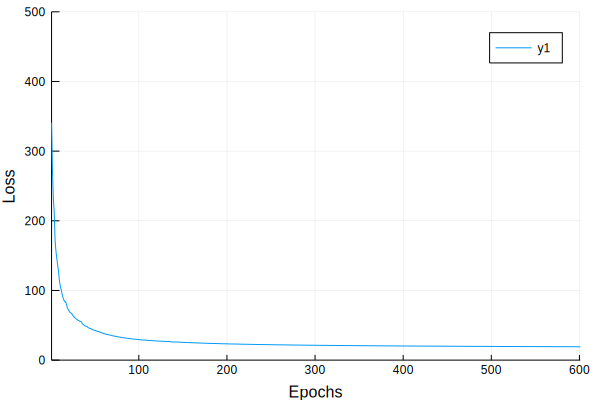

In [278]:
plot(losses,xlabel="Epochs",ylabel="Loss",ylim=(0.0,500.0)) 

In [279]:
idx = 5
imshow(Array{Ftype}(w[end])[:,:,1,1]);
imshow(Array{Ftype}(xtrn)[:,:,1,idx]);
imshow(Array{Ftype}(predict(w,xtrn))[:,:,1,idx]);
imshow(Array{Ftype}(ytrn)[:,:,1,idx]);

# Testing gradients

In [53]:
# Testing the gradient: Increasing w[2] (scalar μ) by eps_w should decrease loss by grad_w2 * eps_w2
h = Ftype(1e-1)
num_tests = 3
ldiff = zeros(num_tests,length(w))
vdot(x, y) = sum(vec(x).*vec(y))
for (x,y) in dtst
    println(typeof(x))
    println(typeof(y))
    for i in 1:num_tests
        println("    h: $h")
        for j in 1:length(w)
            w0 = copy(w)
            loss0 = loss(w0,x,y)
            grad0 = lossgradient(w0,x,y)
            eps_w = h * Atype(randn(Ftype,size(w0[j])))
            w0[j] -= eps_w
            loss1 = loss(w0,x,y)
            Δloss = loss1 - loss0
            Δgrad = -vdot(vec(grad0[j]), vec(eps_w))
            ldiff[i,j] = abs(Δloss - Δgrad)
            #println("Δloss[$i]: ", Δloss)
            #println("Δgrad[$i]: ", Δgrad)
        end
        println(" diff: ", ldiff[i,:])
        i > 1 && println("ratio: ", ldiff[i-1,:]./ldiff[i,:])
        h /= 2.0f0
    end
end

Knet.KnetArray{Float32,4}
Knet.KnetArray{Float32,4}
    h: 0.1
 diff: [22.8909, 23.0227, 23.5443, 82.4476, 51.2972, 18.5263, 54.7812, 56.2871, 111.889, 32.8095, 39.5458, 34.9362, 16.5791, 159.094]
    h: 0.05
 diff: [165.367, 836.022, 54.7307, 25.3502, 9.67071, 4.26693, 19.2321, 21.9361, 38.9125, 73.26, 48.4928, 5.86808, 47.8326, 7.28696]
ratio: [0.138425, 0.0275384, 0.430185, 3.25234, 5.30438, 4.34184, 2.84843, 2.56596, 2.87539, 0.447851, 0.815498, 5.9536, 0.346606, 21.8327]
    h: 0.025
 diff: [73.4712, 45.7752, 6.4873, 3.59415, 2.81258, 0.651263, 1.8255, 5.50038, 293.323, 115.847, 4.33093, 7.59124, 26.9382, 17.1977]
ratio: [2.25077, 18.2637, 8.43659, 7.05319, 3.43838, 6.55179, 10.5353, 3.9881, 0.132661, 0.632388, 11.1969, 0.773008, 1.77564, 0.423717]
Knet.KnetArray{Float32,4}
Knet.KnetArray{Float32,4}
    h: 0.0125
 diff: [54.5542, 212.194, 3.20153, 0.840418, 0.737945, 4.58832, 1.39067, 0.812282, 73.7646, 29.9642, 7.35661, 1.87079, 20.3105, 4.05299]
    h: 0.00625
 diff: [2.89911, 8

In [54]:
for (x,y) in dtst
    gradcheck(loss, w, x, y; verbose=true)
end

gcheck: d=135.35732 nd=135.22704
gcheck: d=-17.256958 nd=-17.263025
gcheck: d=-132.43896 nd=-132.34946


gcheck: d=81.03483 nd=81.0566
gcheck: d=-132.43896 nd=-132.39906
gcheck: d=60.244087 nd=60.22198
gcheck: d=66.87149 nd=66.81982
gcheck: d=-129.47887 nd=-129.47269
gcheck: d=278.65378 nd=278.58887
gcheck: d=-96.46739 nd=-96.4375
gcheck: d=-32.63891 nd=-32.625
gcheck: d=-104.087746 nd=-104.125
gcheck: d=131.15106 nd=131.125
gcheck: d=-91.97578 nd=-92.0


gcheck: d=-88.41452 nd=-88.375
gcheck: d=-104.087746 nd=-104.0625
gcheck: d=-86.7276 nd=-86.75
gcheck: d=48.626648 nd=48.66441
gcheck: d=16.778938 nd=16.772686
gcheck: d=-96.352875 nd=-96.38388
gcheck: d=-58.151463 nd=-58.192554
gcheck: d=-165.54521 nd=-165.52199
gcheck: d=56.003304 nd=56.02707
gcheck: d=-51.359627 nd=-51.34174
gcheck: d=-103.27675 nd=-103.27407


gcheck: d=44.753284 nd=44.766533
gcheck: d=-34.950695 nd=-34.96278
gcheck: d=109.6631 nd=109.69179


gcheck: d=109.6631 nd=109.613045
gcheck: d=109.6631 nd=109.69179
gcheck: d=79.64308 nd=79.6112
gcheck: d=40.274815 nd=40.31744
gcheck: d=335.18845 nd=335.21747
gcheck: d=119.29025 nd=119.21993
gcheck: d=283.896 nd=283.95447
gcheck: d=-172.92583 nd=-172.92403
gcheck: d=-28.7787 nd=-28.820671
gcheck: d=283.896 nd=283.95447
gcheck: d=335.18845 nd=335.21747
gcheck: d=-145.42209 nd=-145.39635
gcheck: d=-125.159874 nd=-125.15694
gcheck: d=-109.78865 nd=-109.72901
gcheck: d=-275.1388 nd=-275.16666


gcheck: d=-177.0417 nd=-176.99521
gcheck: d=-109.38666 nd=-109.3821
gcheck: d=-90.556564 nd=-90.53167
gcheck: d=-113.88885 nd=-113.84667
gcheck: d=-259.1242 nd=-259.0942


gcheck: d=172.89618 nd=172.75
gcheck: d=501.43835 nd=501.3125
gcheck: d=1064.7478 nd=1064.25


gcheck: d=38.018486 nd=38.0
gcheck: d=-31.266869 nd=-31.25
gcheck: d=-123.62665 nd=-123.625
gcheck: d=-73.65943 nd=-73.625
gcheck: d=92.680855 nd=92.625
gcheck: d=99.922775 nd=99.875
gcheck: d=-226.45404 nd=-226.5
gcheck: d=54.27318 nd=54.255306
gcheck: d=-51.52768 nd=-51.577976
gcheck: d=-57.52496 nd=-57.562595


gcheck: d=50.38418 nd=50.3968
gcheck: d=93.18991 nd=93.155334
gcheck: d=57.776154 nd=57.798832
gcheck: d=70.81013 nd=70.791756
gcheck: d=13.842267 nd=13.85912


gcheck: d=41.286446 nd=41.262383
gcheck: d=39.651127 nd=39.68748
gcheck: d=45.50427 nd=45.435867
gcheck: d=-2.3756218 nd=-2.3811069
gcheck: d=191.98499 nd=191.92714
gcheck: d=162.06711 nd=161.96487
gcheck: d=65.680176 nd=65.62906
gcheck: d=156.85703 nd=156.90503


gcheck: d=-21.065315 nd=-21.082718
gcheck: d=133.5229 nd=133.49081
gcheck: d=52.62127 nd=52.632385
gcheck: d=-69.469986 nd=-69.548164
gcheck: d=-111.24867 nd=-111.11799


gcheck: d=42.804314 nd=42.76071
gcheck: d=-29.203026 nd=-29.168516
gcheck: d=23.532623 nd=23.513432


gcheck: d=1087.4575 nd=1086.2085
gcheck: d=-178.28958 nd=-178.25
gcheck: d=-384.10718 nd=-384.0
gcheck: d=171.90573 nd=171.9375
gcheck: d=171.90573 nd=171.9375
gcheck: d=171.90573 nd=171.875
gcheck: d=-335.1856 nd=-334.875
gcheck: d=171.90573 nd=171.9375
gcheck: d=99.614494 nd=99.625
gcheck: d=42.044415 nd=42.04983
gcheck: d=-52.028023 nd=-52.050446
gcheck: d=-80.31273 nd=-80.3199
gcheck: d=121.01402 nd=121.03107
gcheck: d=136.15651 nd=136.1501
gcheck: d=42.044415 nd=42.04983
gcheck: d=83.86984 nd=83.94217


gcheck: d=-60.491886 nd=-60.554905
gcheck: d=-80.79993 nd=-80.85842
gcheck: d=63.722908 nd=63.793823
gcheck: d=-121.71699 nd=-121.73409
gcheck: d=-138.30942 nd=-138.35223
gcheck: d=-131.30058 nd=-131.25851
gcheck: d=59.819695 nd=59.825176
gcheck: d=-19.359097 nd=-19.346495
gcheck: d=11.2092705 nd=11.211045
gcheck: d=64.906845 nd=64.88516


gcheck: d=-105.65699 nd=-105.66162
gcheck: d=42.033638 nd=42.066223
gcheck: d=100.01557 nd=100.105705
gcheck: d=27.26643 nd=27.282856
gcheck: d=147.44653 nd=147.42664
gcheck: d=-12.306878 nd=-12.302386
gcheck: d=88.90492 nd=88.99387
gcheck: d=-98.00871 nd=-98.02223
gcheck: d=-167.55692 nd=-167.5208
gcheck: d=-167.55692 nd=-167.5704
gcheck: d=-194.37938 nd=-194.40746
gcheck: d=-147.06094 nd=-147.03336


gcheck: d=113.76544 nd=113.74746
gcheck: d=-107.842575 nd=-107.893906
gcheck: d=-98.00871 nd=-97.972626
gcheck: d=-63.814545 nd=-63.793823
gcheck: d=-96.67969 nd=-96.53404


gcheck: d=-278.50812 nd=-278.78793
gcheck: d=0.54880905 nd=0.54567033
gcheck: d=39.933655 nd=39.933147
gcheck: d=-59.08978 nd=-59.03161
gcheck: d=-267.37778 nd=-267.52728
gcheck: d=54.43596 nd=54.418217
gcheck: d=100.32812 nd=100.35374
gcheck: d=67.95772 nd=67.86155
gcheck: d=-223.16823 nd=-223.47614
gcheck: d=175.39326 nd=175.2098
gcheck: d=-365.27368 nd=-365.10306


gcheck: d=-42.40323 nd=-42.413467
gcheck: d=58.08903 nd=58.138695
gcheck: d=-132.5105 nd=-132.49867
gcheck: d=-24.691269 nd=-24.703985
gcheck: d=18.109722 nd=18.155941
gcheck: d=-37.572178 nd=-37.601646
gcheck: d=-63.244095 nd=-63.29776
gcheck: d=-158.45097 nd=-158.44258
gcheck: d=-88.46575 nd=-88.3986
gcheck: d=-20.04084 nd=-19.991377
gcheck: d=-38.995613 nd=-39.08984
gcheck: d=-33.207504 nd=-33.186577
gcheck: d=-25.688728 nd=-25.646505
gcheck: d=47.08919 nd=47.026863
gcheck: d=32.176083 nd=32.144848
gcheck: d=-37.872856 nd=-37.849678
gcheck: d=-66.48845 nd=-66.47257


gcheck: d=-28.253416 nd=-28.226038
gcheck: d=-34.483078 nd=-34.52605
gcheck: d=-31.27827 nd=-31.351242
gcheck: d=35.375397 nd=35.369358


gcheck: d=59.90058 nd=59.924526
gcheck: d=-38.55629 nd=-38.54417
gcheck: d=72.19289 nd=72.22691
gcheck: d=-114.074196 nd=-114.0451
gcheck: d=-32.03996 nd=-32.04573
gcheck: d=30.449879 nd=30.458326
gcheck: d=22.847805 nd=22.818941
gcheck: d=-45.53927 nd=-45.53867
gcheck: d=28.904173 nd=28.870922
gcheck: d=109.64914 nd=109.630135
gcheck: d=100.5103 nd=100.55216
gcheck: d=-11.390888 nd=-11.409436
gcheck: d=31.427097 nd=31.351242


gcheck: d=28.904173 nd=28.920528


# Linear regression testing with imfilter

In [350]:
# define types
srand(42)
Ftype = Float64
Atype = Array{Ftype};

In [352]:
# Initialize model
m, n = 50, 60

xp, yp = linspace(-pi,pi,m), linspace(-pi,pi,n)'
Wx, Wy = 1:5, 1:5
idx = 1
y = zeros(m,n,1,length(Wx)*length(Wy))
for (ωx,ωy) in Iterators.product(Wx,Wy)
    y[:,:,1,idx] = Atype( sin.(ωx*xp) .* cos.(ωy*yp) );
    idx += 1
end
x = Atype(y + 0.5randn(Ftype,size(y)));
w = [ Atype(0.1*randn(5,5,1,1)), Ftype(1.0) ];

In [353]:
#z = imfilter(x,centered(w));
z = conv4(w[1],x,padding=1);

In [354]:
# Define loss
predict(w,x) = conv4(w[1],x,padding=div(size(w[1],1),2)) .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);

In [355]:
w0 = w[2]
loss0 = loss(w,x,y)

1.2025514132303978

In [356]:
# Testing the gradient: Increasing w[2] by eps_w should decrease loss by 1.9996 * eps_w
grad0 = lossgradient(w,x,y)
eps_w = 0.0001
w[2] = w0 - eps_w
loss1 = loss(w,x,y);

In [357]:
loss1 - loss0

-0.0002000528670471624

In [358]:
-grad0[2] * eps_w

-0.00020006286704758562

In [359]:
# SGD training loop
function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

train! (generic function with 1 method)

In [366]:
# Record the weights for 10 epochs
@time weights = [ copy(train!(w, [(x, y)])) for epoch=1:10 ];
weights[end][1]

 24.838604 seconds (62.24 M allocations: 2.198 GiB, 25.63% gc time)


5×5×1×1 Array{Float64,4}:
[:, :, 1, 1] =
  0.0603571   0.0132552  0.063892   0.0274858   0.0322449
 -0.0333668   0.0864598  0.0876568  0.0515261   0.0370344
  0.0357426   0.0624823  0.0490681  0.055675    0.0754124
  0.0435113   0.164827   0.0843678  0.0341362  -0.0110172
  0.0517037  -0.0553282  0.0563687  0.0313654   0.0773658

In [367]:
losses = [ loss(w,x,y) for w in weights ]

10-element Array{Float64,1}:
 0.0554632
 0.0504583
 0.0466408
 0.043643 
 0.0412238
 0.0392236
 0.0375355
 0.0360866
 0.0348267
 0.0337199

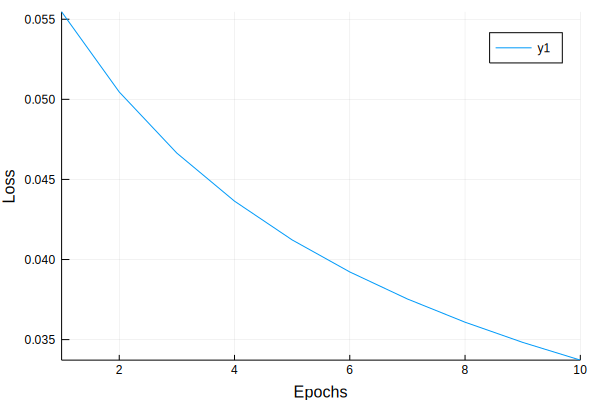

In [368]:
plot(losses,xlabel="Epochs",ylabel="Loss") 

In [369]:
idx = 16
imshow(w[1][:,:,1,1]);
imshow(x[:,:,1,idx]);
imshow(predict(w,x)[:,:,1,idx]);
imshow(y[:,:,1,idx]);

# Linear regression example with housing data

In [3]:
# Download the housing dataset from the UCI Machine Learning Repository
include(Pkg.dir("Knet","data","housing.jl"))
x,y = housing()
map(summary,(x,y))

INFO: Downloading https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data to /home/jon/.julia/v0.6/Knet/data/housing/housing.data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 49082  100 49082    0     0  78749      0 --:--:-- --:--:-- --:--:-- 78657


("13×506 Array{Float64,2}", "1×506 Array{Float64,2}")

In [5]:
# Define loss
predict(w,x) = w[1]*x .+ w[2]
loss(w,x,y) = mean(abs2,y-predict(w,x))
lossgradient = grad(loss);

In [6]:
# Initialize model
srand(42)
w = [ 0.1*rand(1,13), 0.0 ]

2-element Array{Any,1}:
  [0.0533183 0.0454029 … 0.0160006 0.0422956]
 0.0                                         

In [8]:
loss(w,x,y)

594.4352393887679

In [9]:
lossgradient(w,x,y)

2-element Array{Any,1}:
    [7.53003 -6.79923 … -6.369 13.8655]
 -45.0656                              

In [10]:
# Testing the gradient: Increasing w[2] by eps should decrease loss by 45.0656 * eps
w[2]=0.1

0.1

In [11]:
loss(w,x,y)

589.9386781239456

In [12]:
# SGD training loop
function train!(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

train! (generic function with 1 method)

In [13]:
# Record the weights for 10 epochs
@time weights = [ copy(train!(w, [(x, y)])) for epoch=1:10 ]

  0.215568 seconds (440.65 k allocations: 17.270 MiB, 4.48% gc time)


10-element Array{Array{Any,1},1}:
 Any[[-0.699684 0.725326 … 0.652901 -1.34426], 4.58656]
 Any[[-0.551026 0.513913 … 0.565058 -1.53221], 8.17581]
 Any[[-0.59464 0.518516 … 0.634074 -1.88846], 11.0472] 
 Any[[-0.590579 0.487521 … 0.663802 -2.1303], 13.3443] 
 Any[[-0.594767 0.473771 … 0.698189 -2.33759], 15.182] 
 Any[[-0.596189 0.463224 … 0.727585 -2.50545], 16.6522]
 Any[[-0.598128 0.457414 … 0.754282 -2.64491], 17.8283]
 Any[[-0.600288 0.454846 … 0.777929 -2.7612], 18.7692] 
 Any[[-0.602933 0.455003 … 0.798796 -2.8591], 19.5219] 
 Any[[-0.606062 0.457353 … 0.817038 -2.94219], 20.1241]

In [14]:
losses = [ loss(w,x,y) for w in weights ]

10-element Array{Float64,1}:
 364.412 
 240.165 
 161.982 
 112.161 
  80.3404
  59.9844
  46.9397
  38.5626
  33.1684
  29.6825

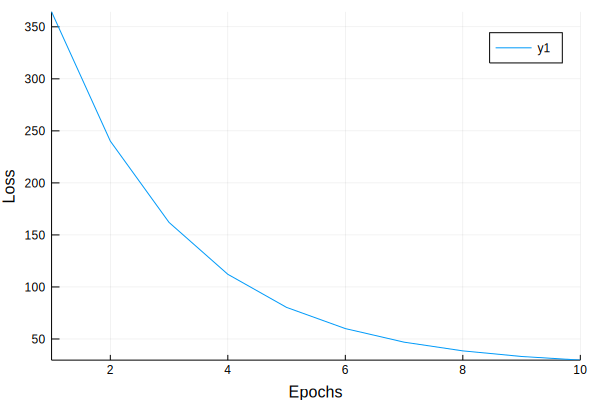

In [17]:
plot(losses,xlabel="Epochs",ylabel="Loss") 

# Load and minibatch MNIST data

In [18]:
include(Knet.dir("data","mnist.jl"))
xtrn,ytrn,xtst,ytst = mnist()
Atype = gpu() >= 0 ? KnetArray{Float32} : Array{Float32}
dtst = minibatch(xtst,ytst,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100
dtrn = minibatch(xtrn,ytrn,100;xtype=Atype); # [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

In [20]:
# dtrn and dtst are iterables of (x,y) minibatches, each minibatch contains 100 instances
length(dtrn),length(dtst)

(600, 100)

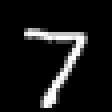

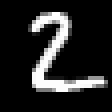

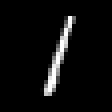

3-element Array{UInt8,1}:
 0x07
 0x02
 0x01

In [22]:
# Take a look at the first three test images and labels
(x,y) = first(dtst)
ax = Array(x)
for i=1:3; display(mnistview(ax,i)); end
y[1:3]

# Softmax classification example with MNIST

## Define softmax loss

In [27]:
# Define loss
predict(w,x) = w[1]*mat(x) .+ w[2]  # Same as linreg except we need mat() to convert input 4D->2D before matmul
loss(w,x,ygold) = nll(predict(w,x),ygold); # nll is negative log likelihood

In [28]:
# Initialize model
wsoft=map(Atype, [ 0.1*randn(10,784), zeros(10,1) ]);

In [30]:
# Average loss for a single (x,y) minibatch
loss(wsoft, x, y)

2.830448f0

In [31]:
# Average loss for the whole test set
nll(wsoft,dtst,predict)

2.8376572f0

In [32]:
# Accuracy for the whole test set
accuracy(wsoft,dtst,predict)

0.0407

## Train softmax model

In [33]:
@time softmodels = [ copy(train!(wsoft, dtrn)) for epoch=1:60 ];  # ~17 seconds

 27.146815 seconds (23.55 M allocations: 19.056 GiB, 6.95% gc time)


## Plot softmax learning curve

In [34]:
@time trnsoftloss = [ nll(w,dtrn,predict) for w in softmodels ];  # ~13 seconds
@time tstsoftloss = [ nll(w,dtst,predict) for w in softmodels ];  # ~2 seconds

  7.467384 seconds (5.20 M allocations: 11.492 GiB, 13.65% gc time)
  1.332153 seconds (874.87 k allocations: 1.916 GiB, 13.19% gc time)


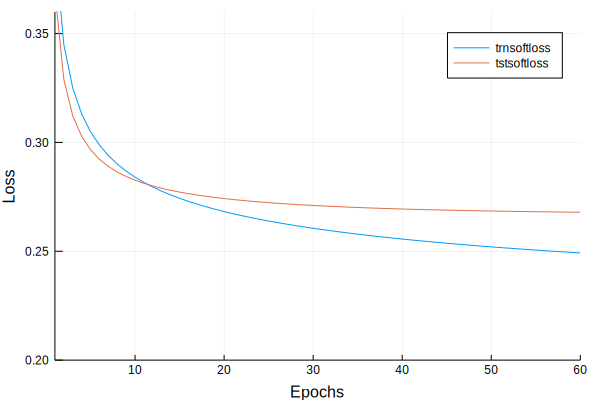

In [36]:
plot([trnsoftloss tstsoftloss],ylim=(.2,.36),labels=[:trnsoftloss :tstsoftloss],xlabel="Epochs",ylabel="Loss") 

## Plot softmax error rate

In [37]:
@time trnsofterr = [ 1-accuracy(w,dtrn,predict) for w in softmodels ];  # ~12 seconds
@time tstsofterr = [ 1-accuracy(w,dtst,predict) for w in softmodels ];  # ~2 seconds

  6.153225 seconds (3.33 M allocations: 11.134 GiB, 15.74% gc time)
  1.062067 seconds (562.73 k allocations: 1.856 GiB, 15.49% gc time)


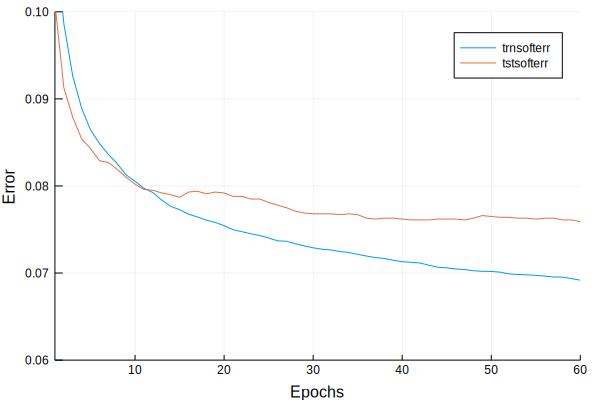

In [39]:
plot([trnsofterr tstsofterr],ylim=(.06,.10),labels=[:trnsofterr :tstsofterr],xlabel="Epochs",ylabel="Error")

In [40]:
# Cleanup
wsoft = softmodels = nothing; knetgc()

# Multilayer perceptron example with MNIST

In [41]:
# We only need to change the predict function!
function predict(w,x)
    for i=1:2:length(w)
        x = w[i]*mat(x) .+ w[i+1]
        if i<length(w)-1
            x = max.(0,x)                         
        end
    end
    return x
end

predict (generic function with 1 method)

In [43]:
wmlp=map(Atype, [ 0.1*randn(64,784), zeros(64,1), 
                  0.1*randn(10,64),  zeros(10,1) ])
loss(wmlp, x, y)  # average loss for random model should be close to log(10)=2.3026

2.4366724f0

## Train MLP model

In [44]:
@time mlpmodels = [ copy(train!(wmlp, dtrn)) for epoch=1:60 ]; # ~20 seconds

 60.059827 seconds (39.31 M allocations: 58.845 GiB, 9.66% gc time)


## Compare MLP loss with softmax loss

In [45]:
@time trnmlploss = [ nll(w,dtrn,predict) for w in mlpmodels ]; # ~12 seconds
@time tstmlploss = [ nll(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds

 13.244330 seconds (7.18 M allocations: 14.151 GiB, 10.61% gc time)
  2.302616 seconds (1.20 M allocations: 2.359 GiB, 10.41% gc time)


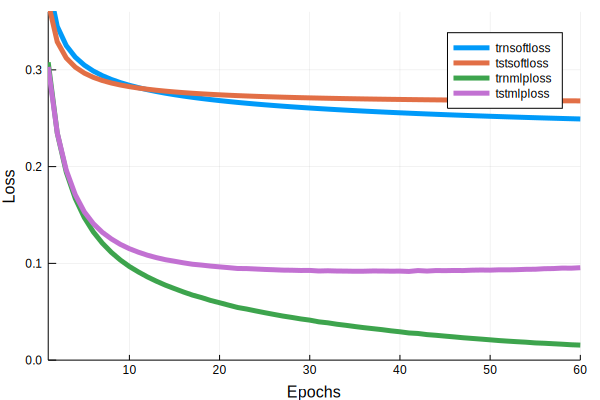

In [50]:
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss],
    xlabel="Epochs",ylabel="Loss",linewidth=5,ylim=(.0,.36),
    labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss]) 

## Compare MLP error with softmax error

In [51]:
@time trnmlperr = [ 1-accuracy(w,dtrn,predict) for w in mlpmodels ]; # ~13 seconds
@time tstmlperr = [ 1-accuracy(w,dtst,predict) for w in mlpmodels ]; # ~2 seconds

 10.386532 seconds (5.31 M allocations: 13.793 GiB, 12.48% gc time)
  1.744261 seconds (892.73 k allocations: 2.299 GiB, 12.66% gc time)


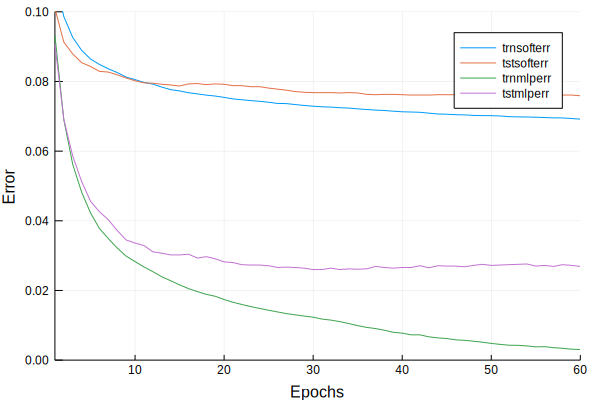

In [53]:
plot([trnsofterr tstsofterr trnmlperr tstmlperr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr],xlabel="Epochs",ylabel="Error")

In [54]:
# Cleanup
wmlp = mlpmodels = nothing; knetgc()

# CNN example with MNIST (The LeNet model)

In [55]:
# We only need to change the predict function!
function predict(w,x) # LeNet model
    n=length(w)-4
    for i=1:2:n
        x = pool(relu.(conv4(w[i],x) .+ w[i+1]))
    end
    for i=n+1:2:length(w)-2
        x = relu.(w[i]*mat(x) .+ w[i+1])
    end
    return w[end-1]*x .+ w[end]
end

predict (generic function with 1 method)

In [57]:
wcnn=map(Atype, [ 0.1*randn(5,5,1,20),  zeros(1,1,20,1), 
                  0.1*randn(5,5,20,50), zeros(1,1,50,1),
                  0.1*randn(500,800),  zeros(500,1),
                  0.1*randn(10,500),  zeros(10,1) ])
loss(wcnn, x, y)

4.1054115f0

## Train CNN model

In [ ]:
@time cnnmodels = [ copy(train!(wcnn, dtrn)) for epoch=1:60 ]; # ~127 seconds

## Compare CNN loss with MLP

In [ ]:
@time trncnnloss = [ nll(w,dtrn,predict) for w in cnnmodels ]; # ~48 seconds
@time tstcnnloss = [ nll(w,dtst,predict) for w in cnnmodels ]; # ~8 seconds

In [ ]:
plot([trnsoftloss tstsoftloss trnmlploss tstmlploss trncnnloss tstcnnloss],ylim=(.0,.36),labels=[:trnsoftloss :tstsoftloss :trnmlploss :tstmlploss :trncnnloss :tstcnnloss],xlabel="Epochs",ylabel="Loss") 

## Compare CNN error with MLP

In [ ]:
@time trncnnerr = [ 1-accuracy(w,dtrn,predict) for w in cnnmodels ]; # ~48 seconds
@time tstcnnerr = [ 1-accuracy(w,dtst,predict) for w in cnnmodels ]; # ~8 seconds

In [ ]:
plot([trnsofterr tstsofterr trnmlperr tstmlperr trncnnerr tstcnnerr],ylim=(.0,.10),labels=[:trnsofterr :tstsofterr :trnmlperr :tstmlperr :trncnnerr :tstcnnerr],xlabel="Epochs",ylabel="Error")

In [42]:
# Cleanup
wcnn = cnnmodels = nothing; knetgc()

# Shakespeare example

In [43]:
# Please see charlm.ipynb for training a character based language model on "The Complete Works of William Shakespeare"

# VGG example

In [44]:
include(Knet.dir("examples/vgg/vgg.jl"));

In [ ]:
caturl = "https://github.com/BVLC/caffe/raw/master/examples/images/cat.jpg"
catfile = download(caturl)
load(catfile)

In [47]:
VGG.main(catfile)

vgg.jl (c) Deniz Yuret, İlker Kesen, 2016. Classifying images with the VGG model from http://www.robots.ox.ac.uk/~vgg/research/very_deep.
opts=(:atype, "KnetArray{Float32}")(:top, 5)(:image, "/dev/shm/dyuret/.julia/v0.6/Knet/data/cat.jpg")(:model, "imagenet-vgg-verydeep-16")


INFO: Loading imagenet-vgg-verydeep-16.mat...


5×2 Array{Any,2}:
 0.27327    "tabby, tabby cat"        
 0.253185   "Egyptian cat"            
 0.248429   "tiger cat"               
 0.060727   "kit fox, Vulpes macrotis"
 0.0561707  "red fox, Vulpes vulpes"  

  5.173264 seconds (61.56 k allocations: 3.428 MiB, 81.30% gc time)


INFO: Classifying


In [48]:
VGG.main("https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg")

vgg.jl (c) Deniz Yuret, İlker Kesen, 2016. Classifying images with the VGG model from http://www.robots.ox.ac.uk/~vgg/research/very_deep.
opts=(:atype, "KnetArray{Float32}")(:top, 5)(:image, "https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg")(:model, "imagenet-vgg-verydeep-16")


INFO: Downloading https://cvimg1.cardekho.com/p/237x156/in/mahindra/torro-25/mahindra-torro-25.jpg
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13411  100 13411    0     0   6702      0  0:00:02  0:00:02 --:--:--  6705
INFO: Classifying


5×2 Array{Any,2}:
 0.899679    "garbage truck, dustcart"                                                   
 0.0654105   "moving van"                                                                
 0.0201083   "crane"                                                                     
 0.00583589  "trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi"
 0.00515393  "snowplow, snowplough"                                                      

  0.039080 seconds (1.85 k allocations: 90.297 KiB)

